## Assignment 1 - Detection Clusters using Node2Vec
## Fraud Analytics(CS6890)

# Team 
- Nikhil Kumar Patel | cs23mtech11013
- Ayush Agarwal | ai23mtech11002

# Node2Vec

In [1]:
! pip install networkx==2.8.8
! pip install node2vec

In [2]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

/DATA/cs23mtech11013/anaconda3/envs/nikhil/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load and preprocess the data
df = pd.read_csv('Payments_Q1.csv')
print(df.shape)
print(df.head())

(130535, 3)
   Sender  Receiver  Amount
0    1309      1011  123051
1    1309      1011  118406
2    1309      1011  112456
3    1309      1011  120593
4    1309      1011  166396


In [4]:
# Construct a graph with weights
G = nx.from_pandas_edgelist(df, 'Sender', 'Receiver', edge_attr='Amount', create_using=nx.Graph())

In [5]:
# Node Embedding with Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


In [6]:
# Get embeddings and perform clustering
embeddings = {node: model.wv[str(node)] for node in G.nodes}
X = list(embeddings.values())

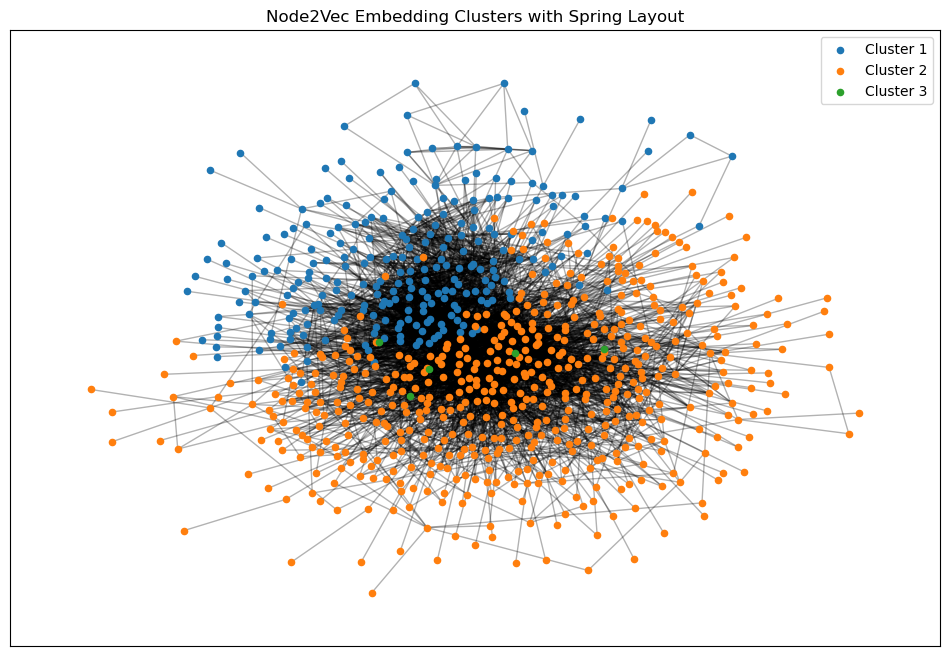

In [7]:
n_clusters=3
kmeans = KMeans(n_clusters, random_state=42,n_init=100)
cluster_labels = kmeans.fit_predict(X)

for node, cluster in zip(G.nodes(), cluster_labels):
    G.nodes[node]['cluster'] = cluster
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(12, 8))

for i in range(n_clusters):
    nx.draw_networkx_nodes(G, pos,node_size=20, nodelist=[n for n in G.nodes if G.nodes[n]['cluster'] == i],
                           node_color=[plt.cm.tab10(i % 10)], label=f'Cluster {i+1}')
# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.legend()
plt.title('Node2Vec Embedding Clusters with Spring Layout')
plt.show()

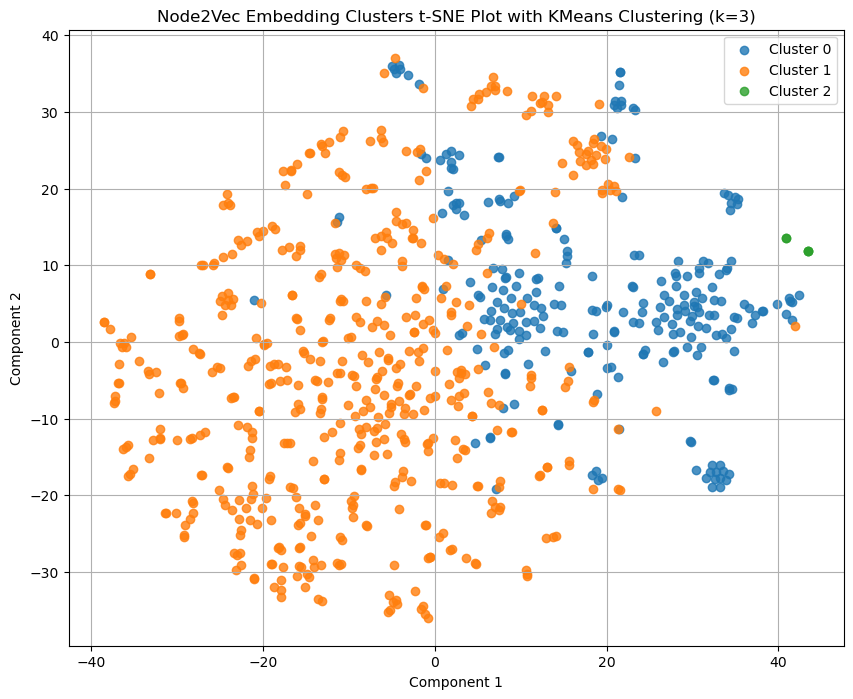

In [8]:
# We have graph 'G' and feature matrix 'X' prepared
X = np.array(X)
# Create t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(X)

k = 3
n_clusters=3
# Cluster using KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Plot t-SNE embeddings colored by cluster labels
plt.figure(figsize=(10, 8))
for cluster_label in range(3):
    plt.scatter(tsne_embeddings[labels == cluster_label, 0],
                tsne_embeddings[labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.8)
plt.title(f'Node2Vec Embedding Clusters t-SNE Plot with KMeans Clustering (k={k})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Spectral Clustering


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.manifold import SpectralEmbedding
from scipy.sparse.linalg import eigsh

In [10]:
df = pd.read_csv('Payments_Q1.csv')
print(df.shape)
print(df.head())

(130535, 3)
   Sender  Receiver  Amount
0    1309      1011  123051
1    1309      1011  118406
2    1309      1011  112456
3    1309      1011  120593
4    1309      1011  166396


In [11]:
# Create an empty undirected graph
undirected_G = nx.Graph()

# Add edges to the graph with amounts as edge attributes
for index, row in df.iterrows():
    undirected_G.add_edge(row['Sender'], row['Receiver'], amount=row['Amount'])

In [12]:
# Compute the Adjacency Matrix
adjacency_matrix = nx.adjacency_matrix(undirected_G)
adjacency_matrix_dense = adjacency_matrix.toarray()
adjacency_matrix_dense.shape

# Compute the degree matrix
degree_matrix = np.diag(np.sum(adjacency_matrix_dense, axis=1))

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adjacency_matrix_dense

# Compute the inverse square root of the degree matrix
inverse_sqrt_degree_matrix = np.diag(1 / np.sqrt(np.sum(adjacency_matrix_dense, axis=1)))

# Compute the normalized Laplacian matrix
normalized_laplacian_matrix = np.dot(inverse_sqrt_degree_matrix, np.dot(laplacian_matrix, inverse_sqrt_degree_matrix))

print(normalized_laplacian_matrix)

[[ 1.         -0.0148544   0.         ...  0.          0.
  -0.05688801]
 [-0.0148544   1.         -0.02752409 ...  0.          0.
   0.        ]
 [ 0.         -0.02752409  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.         -0.4472136
   0.        ]
 [ 0.          0.          0.         ... -0.4472136   1.
   0.        ]
 [-0.05688801  0.          0.         ...  0.          0.
   1.        ]]


In [13]:
# Compute the eigenvalues of the Laplacian
eigenvalues, eigenvectors = eigsh(normalized_laplacian_matrix, k=15, which='SM', return_eigenvectors=True)

# Sort the eigenvalues
eigenvalues = np.sort(eigenvalues)

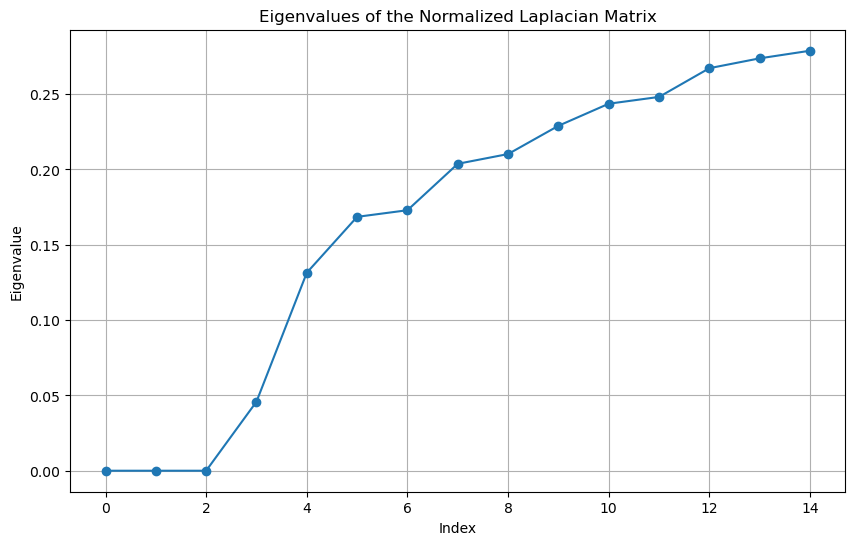

In [14]:
# Plot the eigenvalues to observe the gaps
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Normalized Laplacian Matrix')
plt.grid(True)
plt.show()

In [15]:
adjacency_matrix=nx.adjacency_matrix(undirected_G).toarray()
spectral_embedding = SpectralEmbedding(n_components=3, affinity='rbf')
embeddings = spectral_embedding.fit_transform(adjacency_matrix)

In [16]:
n_clusters=3
kmeans = KMeans(n_clusters, random_state=42,n_init=100)
cluster_labels = kmeans.fit_predict(embeddings)

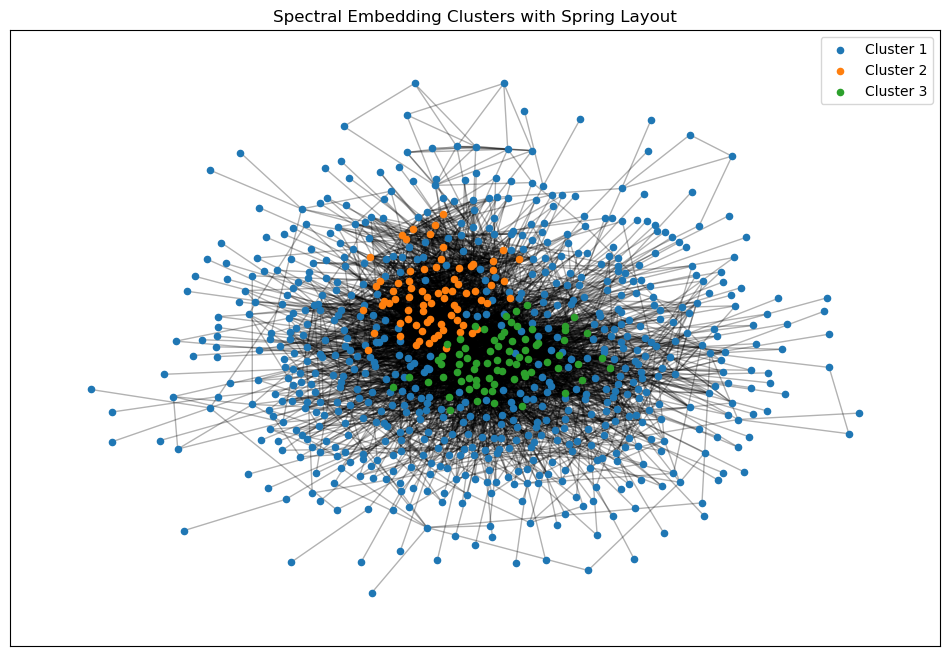

In [17]:
G = undirected_G
for node, cluster in zip(G.nodes(), cluster_labels):
    G.nodes[node]['cluster'] = cluster
pos = nx.kamada_kawai_layout(undirected_G)
plt.figure(figsize=(12, 8))

for i in range(n_clusters):
    nx.draw_networkx_nodes(G, pos,node_size=20, nodelist=[n for n in G.nodes if G.nodes[n]['cluster'] == i],
                           node_color=[plt.cm.tab10(i % 10)], label=f'Cluster {i+1}')
# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.legend()
plt.title('Spectral Embedding Clusters with Spring Layout')
plt.show()


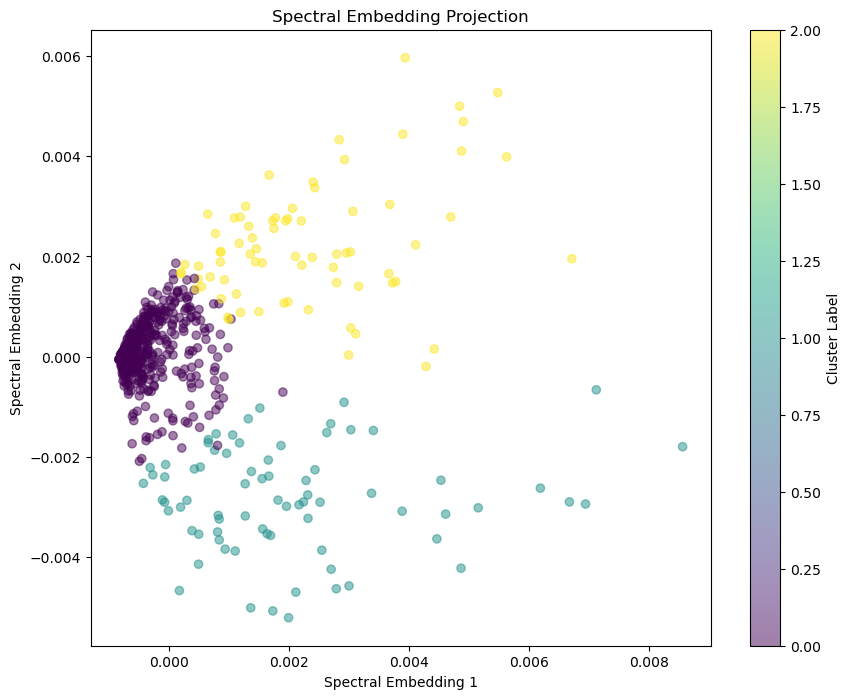

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('Spectral Embedding Projection')
plt.xlabel('Spectral Embedding 1')
plt.ylabel('Spectral Embedding 2')
plt.colorbar(label='Cluster Label')
plt.show()

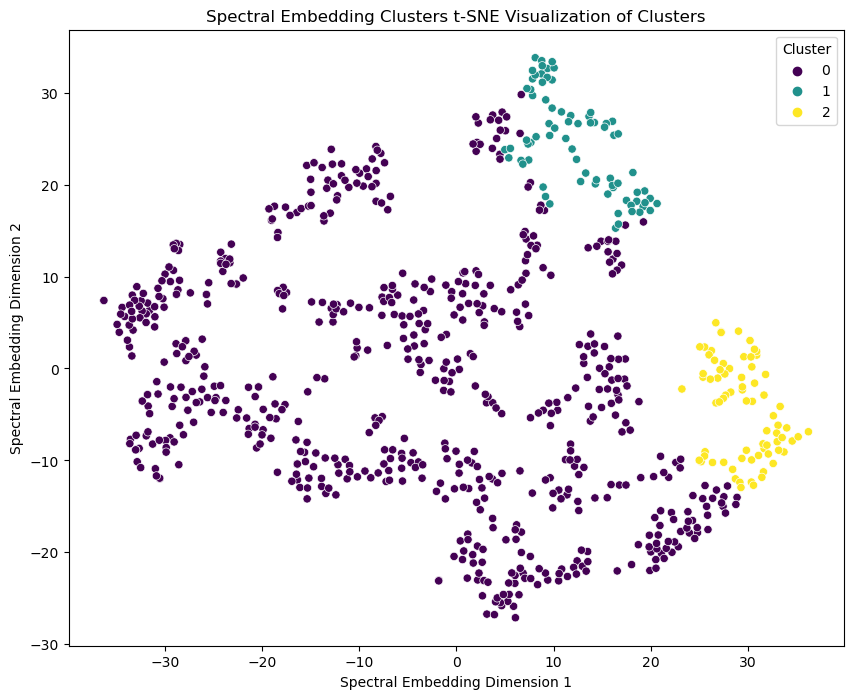

In [19]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Visualize the clusters in t-SNE format
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=cluster_labels, palette='viridis')
plt.title('Spectral Embedding Clusters t-SNE Visualization of Clusters')
plt.xlabel('Spectral Embedding Dimension 1')
plt.ylabel('Spectral Embedding Dimension 2')
plt.legend(title='Cluster')
plt.show()


# GCN

In [20]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/DATA/cs23mtech11013/anaconda3/envs/nikhil/lib/python3.8/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /DATA/cs23mtech11013/anaconda3/envs/nikhil/lib/python3.8/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [21]:
# Step 1: Load and preprocess the data
df = pd.read_csv('Payments_Q1.csv')

In [22]:
# Step 2: Create a graph
G = nx.from_pandas_edgelist(df, 'Sender', 'Receiver', edge_attr='Amount', create_using=nx.DiGraph())

In [23]:
# Convert NetworkX graph to PyTorch Geometric data
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(max(G.nodes)+1, 16)
        self.conv2 = GCNConv(16, 8)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

# Step 3: Generate GCN embeddings
x = torch.eye(max(G.nodes)+1).to(device)  # featureless inputs
edge_index = torch.tensor(list(G.edges)).t().contiguous().to(device)
data = Data(x=x, edge_index=edge_index)

model.eval()
with torch.no_grad():
    out = model(data).cpu().numpy()

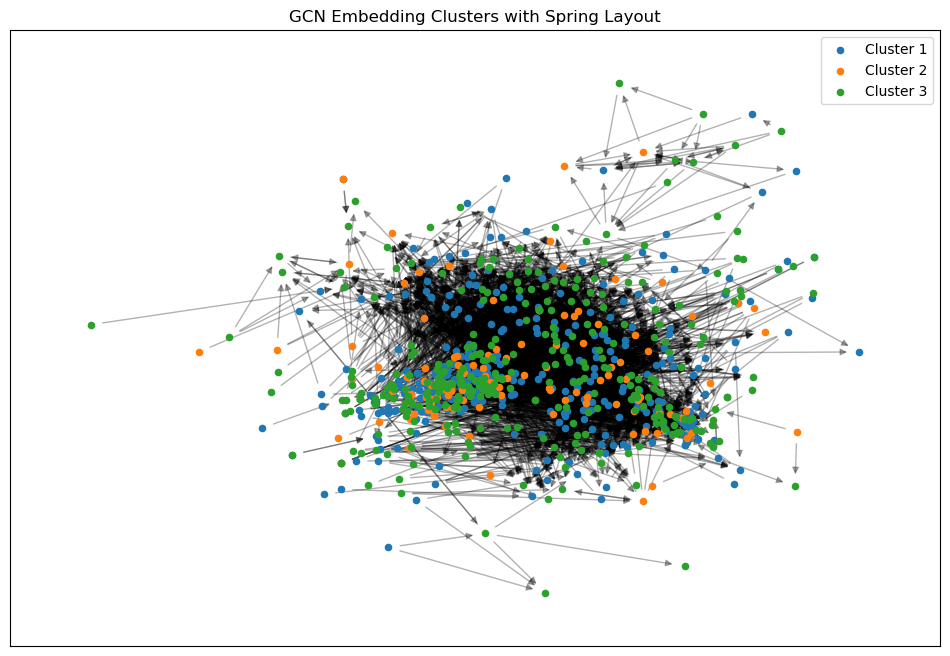

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(out)


for node, cluster in zip(G.nodes(), cluster_labels):
    G.nodes[node]['cluster'] = cluster
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(12, 8))

for i in range(3):
    nx.draw_networkx_nodes(G, pos,node_size=20, nodelist=[n for n in G.nodes if G.nodes[n]['cluster'] == i],
                           node_color=[plt.cm.tab10(i % 10)], label=f'Cluster {i+1}')
# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.legend()
plt.title('GCN Embedding Clusters with Spring Layout')
plt.show()

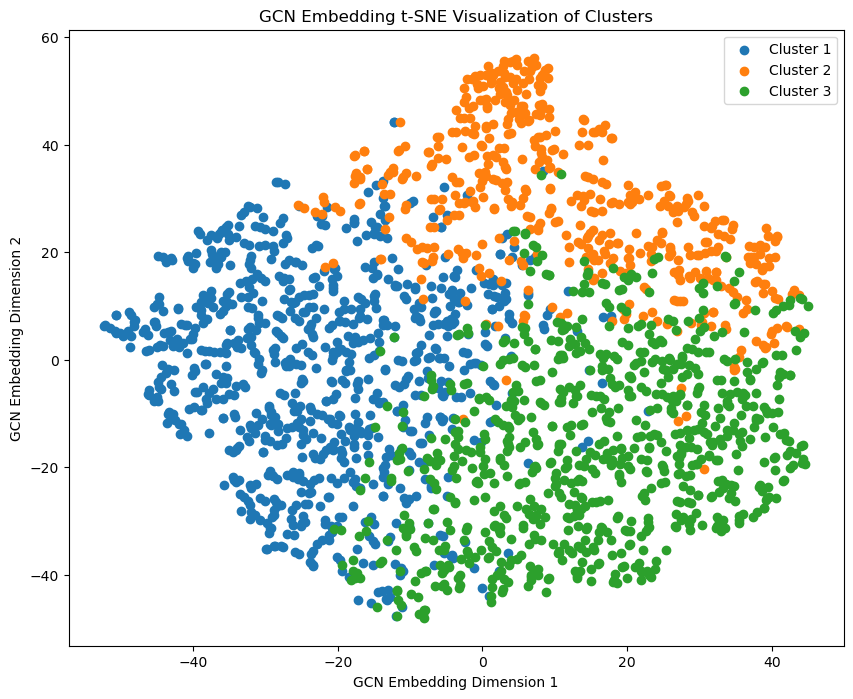

In [26]:

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(out)

# Visualize clusters in t-SNE format
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(out)

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.scatter(embeddings_tsne[cluster_labels == i, 0], embeddings_tsne[cluster_labels == i, 1], label=f'Cluster {i+1}')
plt.title('GCN Embedding t-SNE Visualization of Clusters')
plt.xlabel('GCN Embedding Dimension 1')
plt.ylabel('GCN Embedding Dimension 2')
plt.legend()
plt.show()